# Initial Analysis

In [1]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [31]:
df = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/AKAM.csv', parse_dates=['date'])

df.set_index('date', inplace=True)

# setting frequency
df = df.asfreq('D')

target = df['RET']
exog = df[['VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn', 'TURNOVER', 'DJI_Return']]


<Figure size 1000x500 with 0 Axes>

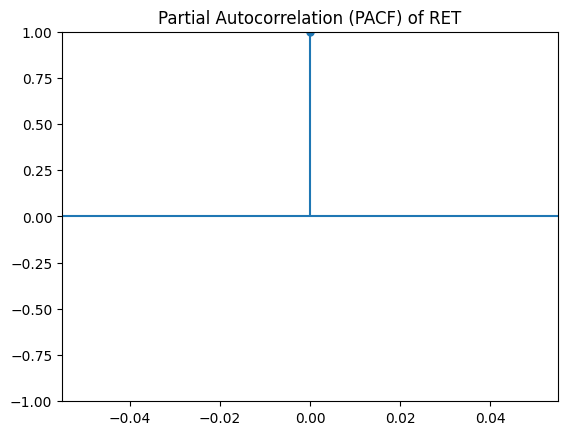

In [24]:
plt.figure(figsize=(10, 5))
plot_pacf(target, lags=20, method='ywm')
plt.title('Partial Autocorrelation (PACF) of RET')
plt.show()

In [32]:
# Try additional lags and choose the optimal lag
aic_values = []
lags = range(1, 21)  # Testing lags from 1 to 20
for lag in lags:
    try:
        model = AutoReg(target.dropna(), lags=lag, exog=exog.dropna()).fit()
        aic_values.append(model.aic)
    except Exception as e:
        aic_values.append(np.nan)  # Append NaN for cases where the model fails

In [33]:
# Find the lag with the minimum AIC value
optimal_lag = lags[np.nanargmin(aic_values)]
print(f'Optimal lag based on AIC: {optimal_lag}')

Optimal lag based on AIC: 1


In [27]:
final_model = AutoReg(target.dropna(), lags=optimal_lag).fit()
print(final_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    RET   No. Observations:                 7806
Model:                     AutoReg(1)   Log Likelihood               17323.593
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Tue, 08 Oct 2024   AIC                         -34641.187
Time:                        09:23:24   BIC                         -34620.299
Sample:                             1   HQIC                        -34634.028
                                 7806                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.002      0.000       0.001       0.002
RET.L1        -0.0294      0.011     -2.597      0.009      -0.052      -0.007
                                    Roots           

with exog variables

In [34]:
final_model = AutoReg(target.dropna(), lags=optimal_lag, exog=exog.dropna()).fit()
print(final_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    RET   No. Observations:                 7806
Model:                   AutoReg-X(1)   Log Likelihood               19788.418
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Tue, 08 Oct 2024   AIC                         -39558.837
Time:                        09:27:34   BIC                         -39496.174
Sample:                             1   HQIC                        -39537.362
                                 7806                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.408e-05      0.000     -0.233      0.816      -0.001       0.001
RET.L1          0.0107      0.008      1.293      0.196      -0.006       0.027
VOL_CHANGE      0.0023      0.000      5.655    

In [35]:
residuals = final_model.resid

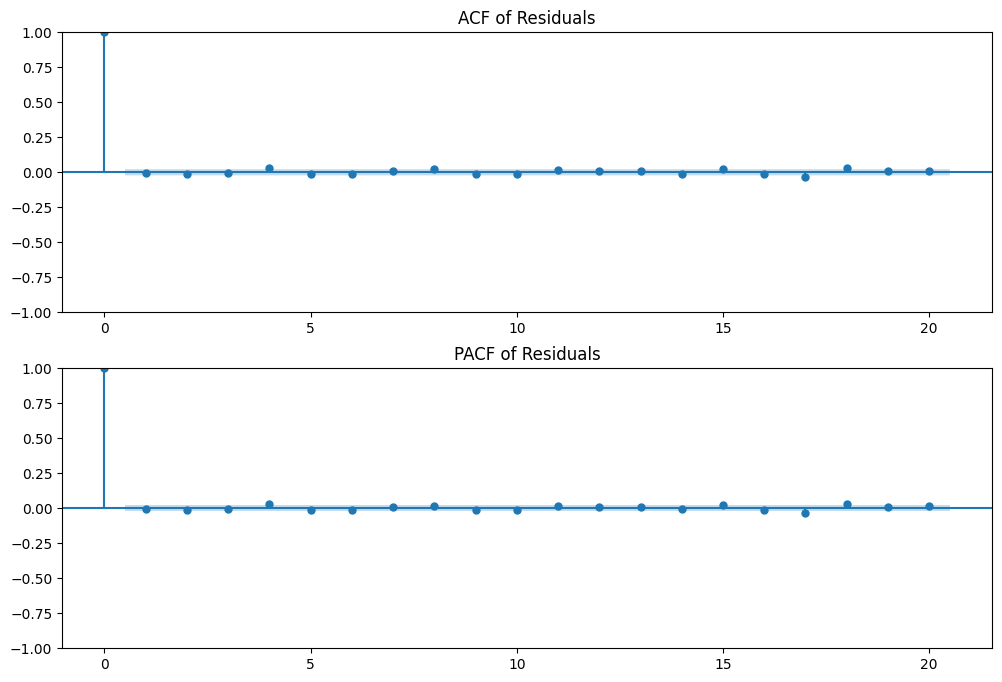

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=20, ax=ax[0])
ax[0].set_title("ACF of Residuals")
plot_pacf(residuals, lags=20, ax=ax[1])
ax[1].set_title("PACF of Residuals")
plt.show()

In [37]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test for Residuals:\n", lb_test)

Ljung-Box Test for Residuals:
       lb_stat  lb_pvalue
10  18.735022    0.04376


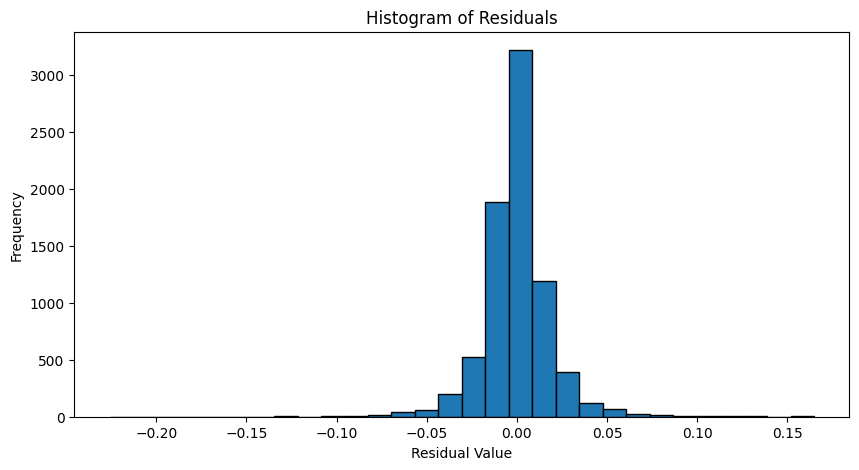

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

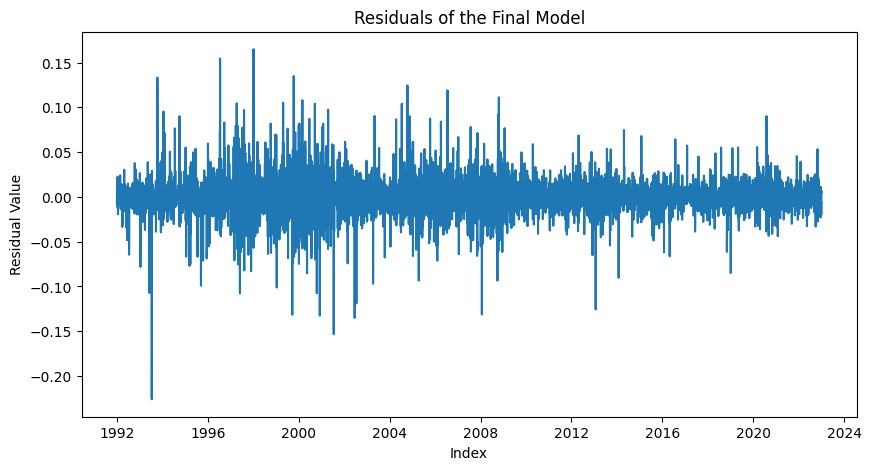

In [40]:
# Plot residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of the Final Model')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.show()

In [28]:
forecast = final_model.predict(start=len(target.dropna()), end=len(target.dropna()) + 9, dynamic=False)


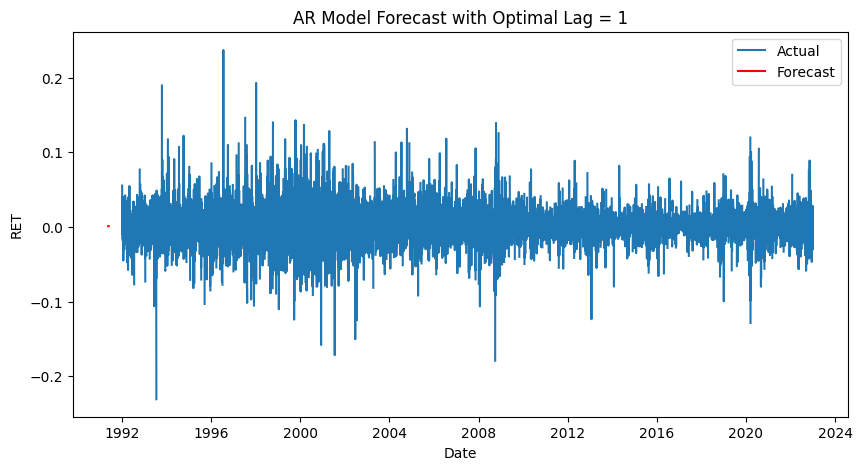

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title(f'AR Model Forecast with Optimal Lag = {optimal_lag}')
plt.xlabel('Date')
plt.ylabel('RET')
plt.legend()
plt.show()

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Checks and plots

Auto Regression (AR) is the kind of model that uses data from the same input variable at previous time steps.
It's principle in predicting the future values is that observations at previous time steps are very significant in predicting the values in the future.
This relationship between observations is known as correlation. There are 2 types of correlation :
Positive Correlation : Both values of the observations move in the same direction
Negative Correlation : Both values of the observations move in the opposite direction
Since the relation between observations at the present times and those in the past times (lag values) is calculated, it is known as Autocorrelation.
The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

In [47]:
def test_stationarity(timeseries):
    """
    This function tests the stationarity of a time series using:
    1. Rolling mean and standard deviation.
    2. Augmented Dickey-Fuller test.

    Parameters:
    - timeseries: The time series to be tested for stationarity.

    Returns:
    - None (Prints out the test results and plots the rolling mean and standard deviation).
    """
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [48]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
     """
    Plot the time series, ACF, PACF, and Dickey-Fuller test results.

    Parameters:
    - y: The time series data (pd.Series or array-like).
    - lags: Number of lags to include in ACF and PACF plots (default: None).
    - figsize: Size of the figure (default: (12, 7)).
    - style: Matplotlib style (default: 'bmh').

    Returns:
    - None (displays the plot).
    """
    #insures input is a pandas series
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

A Time Series consists of the following components :

Trend : Long term direction of the data.

E.g : Year on year rising temperature of the Earth due to Global Warming.

Seasonality : Short term repetitve patterns of the data due to the weather seasons.

E.g : Sale of sweaters specifically in the winter season.

Cyclic Variations : Short term repetitive patterns of the data over a period of 1 year.

E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.

Irregularities : Random and unforseen fluctuations in the data.

E.g : Occurrences of Earthquakes or Floods, etc.

In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.

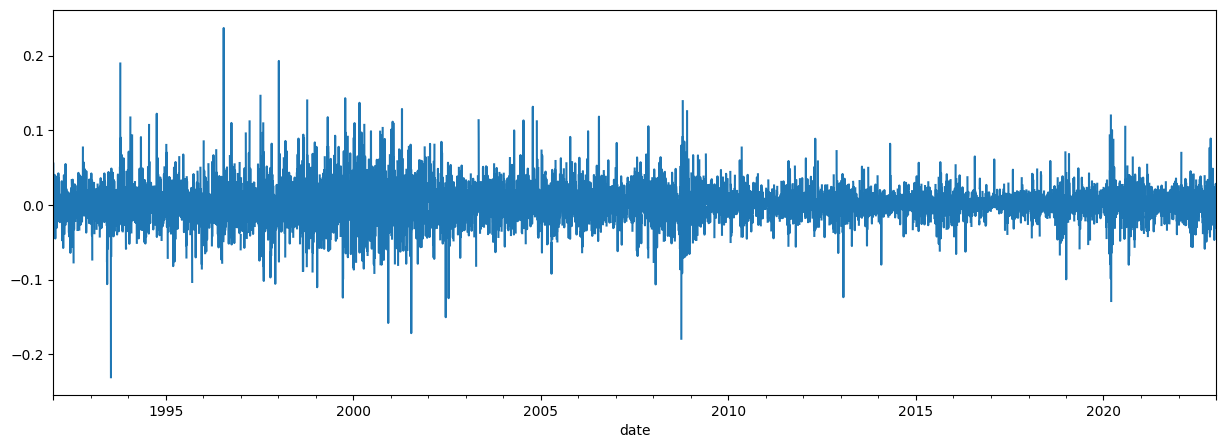

In [49]:
plt.figure(figsize = (15,5))
df['RET'].plot();

Number of missing values in 'RET': 3515
Number of missing values in 'RET' after filling: 0


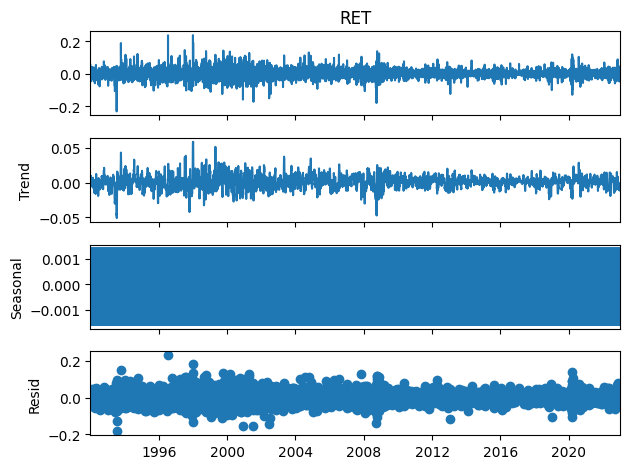

In [51]:
# Check for missing values in the time series
print(f"Number of missing values in 'RET': {df['RET'].isna().sum()}")

# Fill missing values using linear interpolation (or use a different method)
df['RET'] = df['RET'].interpolate(method='linear')

# Check again for missing values after filling
print(f"Number of missing values in 'RET' after filling: {df['RET'].isna().sum()}")

# Step 4: Perform seasonal decomposition
dec = sm.tsa.seasonal_decompose(df['RET'], period=12, model='additive')
dec.plot()
plt.show()


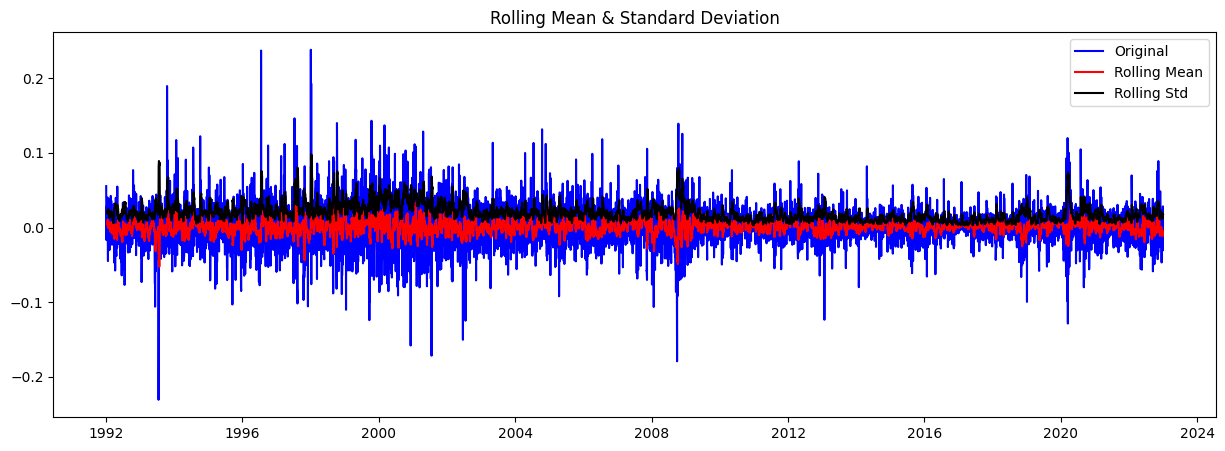

Results of Dickey-Fuller Test:
Test Statistic                  -26.91
p-value                           0.00
#Lags Used                       15.00
Number of Observations Used   11305.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [52]:
test_stationarity(df['RET'])

The test statistic is far below the critical value at the 1% level. This means that the null hypothesis of non-stationarity can be rejected at the 1%, 5%, and 10% levels.

p-value (0.00) < 0.05: The very low p-value further supports rejecting the null hypothesis, indicating that the time series is stationary

- no transformation needed

## AutoRegressive AR

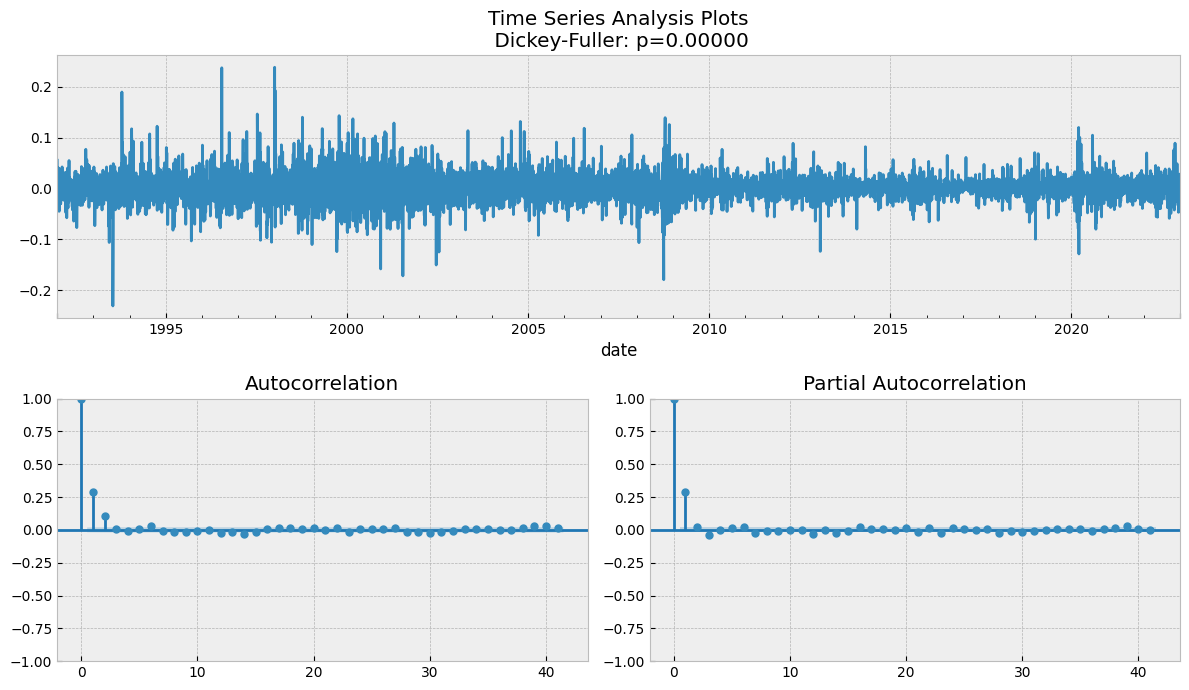

In [54]:
tsplot(df['RET'])

There is a strong autocorrelation at lag 0 (which is expected) and a slightly elevated correlation at lag 1. After that, the autocorrelations quickly drop close to zero, indicating no significant autocorrelation beyond lag 1.

The partial autocorrelation plot displays the correlation of the time series with its lags, after accounting for the effects of intermediate lags.
The PACF also shows a strong correlation at lag 1 and a rapid decline thereafter, suggesting that the series might be best modeled with a simple AR(1) process (an autoregressive model with 1 lag)

In [55]:
model = ARIMA(df['RET'],order = (1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RET   No. Observations:                11321
Model:                 ARIMA(1, 0, 0)   Log Likelihood               26431.602
Date:                Tue, 08 Oct 2024   AIC                         -52857.204
Time:                        11:13:33   BIC                         -52835.201
Sample:                    01-02-1992   HQIC                        -52849.802
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.983      0.000       0.001       0.002
ar.L1          0.2867      0.005     61.025      0.000       0.277       0.296
sigma2         0.0005    3.4e-06    161.656      0.0

In [65]:
import itertools
import statsmodels.api as sm

# Define the p, d, and q ranges to search
p = range(0, 4)  # Try p values from 0 to 3
d = range(0, 3)  # Try d values from 0 to 2
q = range(0, 4)  # Try q values from 0 to 3

# Create combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Iterate over each combination of p, d, q
best_aic = float("inf")  # Initialize with a high value
best_pdq = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(df['RET'], order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
        print(f'ARIMA{param} AIC: {model_fit.aic}')
    except:
        continue

print(f'Best model: ARIMA{best_pdq} with AIC: {best_aic}')



ARIMA(0, 0, 0) AIC: -51888.082696054385
ARIMA(0, 0, 1) AIC: -52737.83674909886
ARIMA(0, 0, 2) AIC: -52875.628147838564
ARIMA(0, 0, 3) AIC: -52874.606281544475
ARIMA(0, 1, 0) AIC: -47865.42707364965
ARIMA(0, 1, 1) AIC: -51875.84114603203
ARIMA(0, 1, 2) AIC: -52722.634198102925
ARIMA(0, 1, 3) AIC: -52859.86341672718
ARIMA(0, 2, 0) AIC: -36435.71480945707
ARIMA(0, 2, 1) AIC: -47844.90784507051
ARIMA(0, 2, 2) AIC: -51512.77962510154
ARIMA(0, 2, 3) AIC: -52607.8647037763
ARIMA(1, 0, 0) AIC: -52857.20376511712
ARIMA(1, 0, 1) AIC: -52860.49629923377
ARIMA(1, 0, 2) AIC: -52874.33961505034
ARIMA(1, 0, 3) AIC: -52872.87728936446
ARIMA(1, 1, 0) AIC: -49551.32819264171
ARIMA(1, 1, 1) AIC: -52841.24301464622
ARIMA(1, 1, 2) AIC: -52842.989034514874
ARIMA(1, 1, 3) AIC: -52753.95798600249
ARIMA(1, 2, 0) AIC: -41810.64897132326
ARIMA(1, 2, 1) AIC: -49529.5683288319
ARIMA(1, 2, 2) AIC: -52743.9905338034
ARIMA(1, 2, 3) AIC: -51837.58472495911
ARIMA(2, 0, 0) AIC: -52861.90492255299
ARIMA(2, 0, 1) AIC: -52

In [67]:
model = ARIMA(df['RET'],order = (0,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RET   No. Observations:                11321
Model:                 ARIMA(0, 0, 2)   Log Likelihood               26441.814
Date:                Tue, 08 Oct 2024   AIC                         -52875.628
Time:                        11:24:08   BIC                         -52846.290
Sample:                    01-02-1992   HQIC                        -52865.758
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.000      0.000       0.001       0.002
ma.L1          0.2808      0.005     55.565      0.000       0.271       0.291
ma.L2          0.1138      0.007     17.169      0.0

## Autoregressive Integrated Moving Average (ARIMA)

ARIMA model is a combination of 3 models :

AR (p) : Auto Regressive
I (d) : Integrated
MA (q) : Moving Average
(p,d,q) is known as the order of the ARIMA model. Values of these parameters are based on the above mentioned models.

p : Number of auto regressive terms.
d : Number of differencing orders required to make the time series stationary.
q : Number of lagged forecast errors in the prediction equation.
Selection criteria for the order of ARIMA model :

p : Lag value where the Partial Autocorrelation (PACF) graph cuts off or drops to 0 for the 1st instance.
d : Number of times differencing is carried out to make the time series stationary.
q : Lag value where the Autocorrelation (ACF) graph crosses the upper confidence interval for the 1st instance.

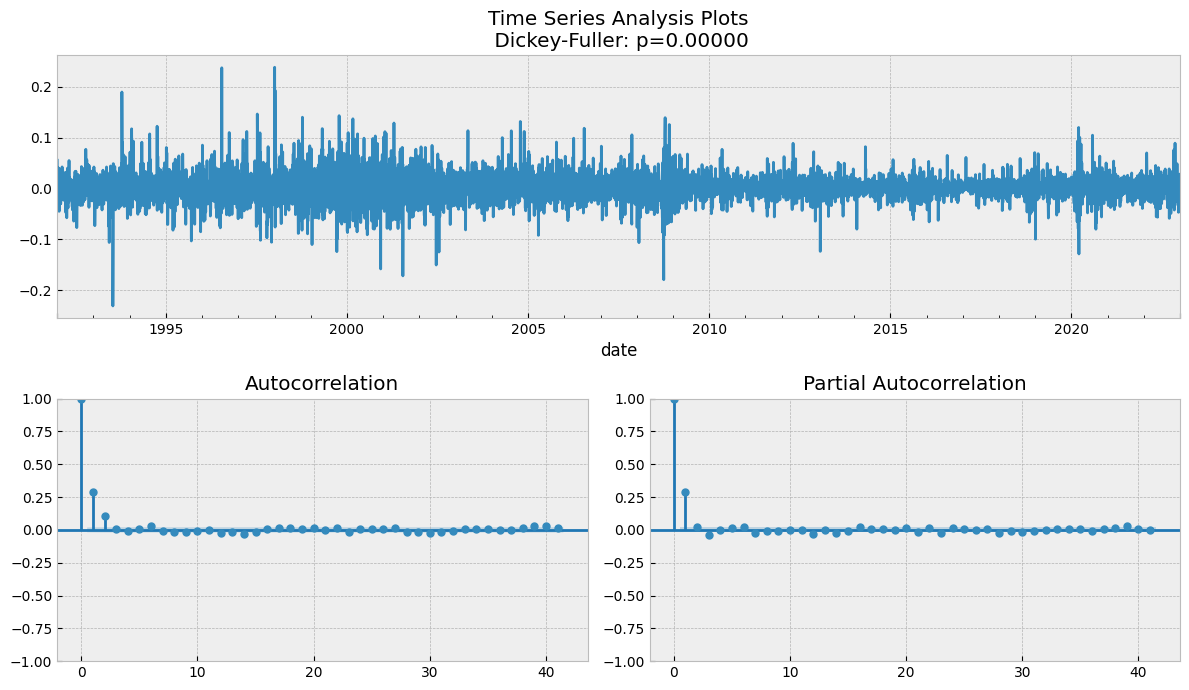

In [69]:
tsplot(df['RET'])

## Vector Auto Regression (VAR)

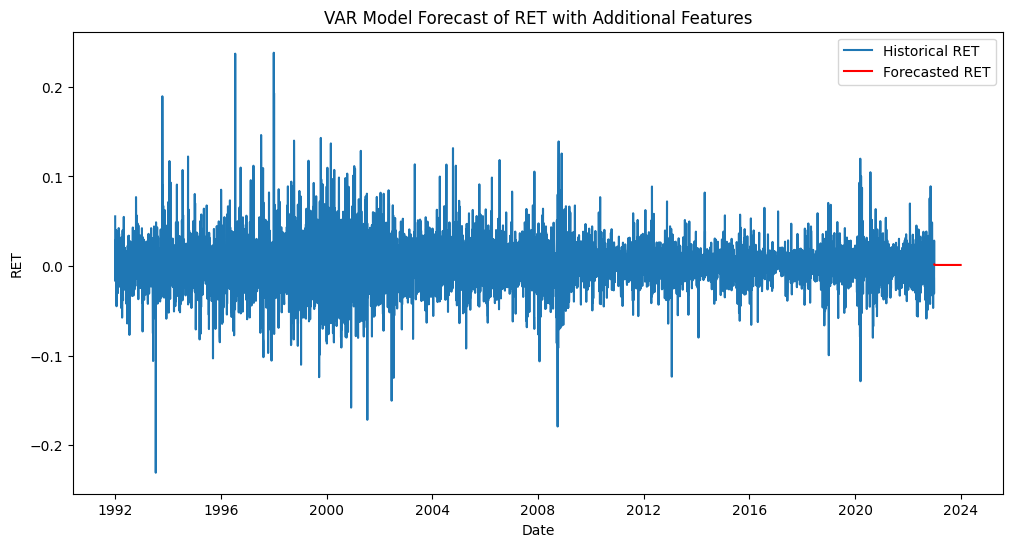

In [74]:
from statsmodels.tsa.api import VAR

# Prepare the data for VAR model
# Combine the target and additional features into a single DataFrame
features = df[['RET', 'VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn', 'TURNOVER', 'DJI_Return']].dropna()

# Fit the VAR model
var_model = VAR(features)
var_results = var_model.fit()

# Forecast the next 365 days
var_forecast = var_results.forecast(features.values[-var_results.k_ar:], steps=365)

# Convert forecast to DataFrame for better readability
var_forecast_df = pd.DataFrame(var_forecast, index=pd.date_range(start=features.index[-1] + pd.Timedelta(days=1), periods=365, freq='D'),
                               columns=features.columns)

# Plot the forecasted RET
plt.figure(figsize=(12, 6))
plt.plot(features['RET'], label='Historical RET')
plt.plot(var_forecast_df['RET'], label='Forecasted RET', color='red')
plt.title('VAR Model Forecast of RET with Additional Features')
plt.xlabel('Date')
plt.ylabel('RET')
plt.legend()
plt.show()


In [75]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
features_scaled = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)


In [76]:
# Determine the optimal number of lags using AIC
var_model = VAR(features_scaled)
lag_order = var_model.select_order(maxlags=15)
print(lag_order.summary())

# Fit the VAR model with the selected number of lags
var_results = var_model.fit(lag_order.aic)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.393      -3.387     0.03359      -3.391
1       -6.079      -6.029    0.002290      -6.062
2       -6.379      -6.285    0.001697      -6.347
3       -6.509      -6.371    0.001490      -6.462
4       -6.587     -6.405*    0.001378      -6.525
5       -6.622      -6.397    0.001330      -6.545
6       -6.644      -6.375    0.001302      -6.552
7       -6.664      -6.352    0.001276      -6.557
8       -6.680      -6.324    0.001256      -6.558
9       -6.699      -6.299    0.001232     -6.562*
10      -6.700      -6.256    0.001231      -6.548
11     -6.705*      -6.217   0.001225*      -6.538
12      -6.702      -6.170    0.001229      -6.519
13      -6.704      -6.128    0.001226      -6.507
14      -6.705      -6.085    0.001225      -6.492
15      -6.704      -6.041    0.001226      -6.477
-------------------------------

## Exponential Smoothing (ES)